In [1]:
import datetime
import re
import pandas as pd
import QuantLib as ql
import pandas as pd
import numpy as np
import yfinance as yf
from yahoo_fin.stock_info import get_quote_table

In [13]:
def option_data(ticker):
    
    opt_sym = yf.Ticker(ticker)
    info = get_quote_table(ticker)
    current_price = info["Quote Price"]
    yield_re = re.compile(r"\((?P<value>(\d+\.\d+))%\)")
    try:
        dividend_yield = float(
            yield_re.search(info["Forward Dividend & Yield"])["value"]
        )
    except (KeyError, ValueError, TypeError):
        dividend_yield = 0.0
    exps = opt_sym.options
    options_ = pd.DataFrame()
    def create_option(row):
        volatility = ql.BlackConstantVol(
            today,
            ql.UnitedStates(),
            row["volatility"],
            ql.Business252()
        )
        option = ql.VanillaOption(
            ql.PlainVanillaPayoff(ql.Option.Call, row["strike"]),
            exercise
        )
        process = ql.BlackScholesMertonProcess(
            ql.QuoteHandle(underlying),
            ql.YieldTermStructureHandle(dividendYield),
            ql.YieldTermStructureHandle(riskFreeRate),
            ql.BlackVolTermStructureHandle(volatility),
        )
        # Calculate it out from the last price
        imp_vol = option.impliedVolatility(row["lastPrice"], process)
        implied_volatility = ql.BlackConstantVol(
            today,
            ql.UnitedStates(),
            imp_vol,
            ql.Business252()
        )
        process = ql.BlackScholesMertonProcess(
            ql.QuoteHandle(underlying),
            ql.YieldTermStructureHandle(dividendYield),
            ql.YieldTermStructureHandle(riskFreeRate),
            ql.BlackVolTermStructureHandle(implied_volatility),
        )
        option.setPricingEngine(
            ql.FdBlackScholesVanillaEngine(process, 1000, 1000)
        )
        return {
            "Name": row["contractSymbol"],
            "Strike": row["strike"],
            "Last": row["lastPrice"],
            "Bid": row["bid"],
            "Ask": row["ask"],
            "NPV": option.NPV(),
            "Delta": option.delta(),
            "Gamma": option.gamma(),
            "Theta": option.theta() / 365,
            "Volatility": imp_vol * 100,
            "IV": row["impliedVolatility"]
        }
        options = calls.apply(create_option, axis=1, result_type="expand")
        
    for e in exps:
        expiration = pd.to_datetime(e) + datetime.timedelta(days = 1)
        opt = opt_sym.option_chain(e)   
        calls = pd.DataFrame().append(opt.calls).append(opt.puts)
        # Setup instruments for Black-Scholes pricing
        today = ql.Date.todaysDate()
        underlying = ql.SimpleQuote(current_price)
        exercise = ql.AmericanExercise(
            today,
        ql.Date(expiration.day, expiration.month, expiration.year))
        dividendYield = ql.FlatForward(
            today, dividend_yield, ql.Actual360()
        )
        riskFreeRate = ql.FlatForward(today, 0.0008913, ql.Actual360())
        # Filter down to only OTM strikes
        calls = calls[calls["strike"] >= current_price * 1.025]
        calls = calls[calls["strike"] <= current_price * 1.10]
        # Parse out implied volatility
        calls = calls.assign(
        volatility=calls["impliedVolatility"],
        )
        options = calls.apply(create_option, axis=1, result_type="expand")
        options_ = options_.append(options, ignore_index=True) 
        options_['Ticker']=ticker
        options_['UnderlyingPrice'] = current_price 
    return options_ [['UnderlyingPrice', 'Ticker', 'Name', 'Strike', 'Last', 'Bid', 'Ask', 'NPV', 'Delta', 'Gamma', 'Theta', 'Volatility', 'IV']]

In [14]:
ticker = "AAPL"
options=option_data(ticker)

In [15]:
options

,UnderlyingPrice,Ticker,Name,Strike,Last,Bid,Ask,NPV,Delta,Gamma,Theta,Volatility,IV
0,121.029999,AAPL,AAPL210319C00125000,125.0,0.66,0.67,0.68,0.661086,0.206343,0.049914,-0.104817,38.301786,0.332526
1,121.029999,AAPL,AAPL210319C00126000,126.0,0.48,0.48,0.50,0.480989,0.160423,0.042475,-0.090285,38.097662,0.335456
2,121.029999,AAPL,AAPL210319C00127000,127.0,0.35,0.34,0.36,0.350770,0.123612,0.035286,-0.076471,38.150926,0.337897
3,121.029999,AAPL,AAPL210319C00127500,127.5,0.30,0.29,0.31,0.300732,0.108438,0.031952,-0.070141,38.276594,0.340827
4,121.029999,AAPL,AAPL210319C00128000,128.0,0.25,0.25,0.28,0.250635,0.093309,0.028654,-0.062694,38.150334,0.348639
...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,121.029999,AAPL,AAPL230120P00130000,130.0,27.50,27.35,27.75,27.789418,0.469785,0.003884,-0.003221,118.306848,0.340217
150,121.029999,AAPL,AAPL230317C00125000,125.0,22.45,22.20,22.40,22.761025,0.454204,0.005154,-0.001778,100.336420,0.353217
151,121.029999,AAPL,AAPL230317C00130000,130.0,20.40,20.50,20.65,20.705763,0.424970,0.005057,-0.001761,98.027025,0.354071
152,121.029999,AAPL,AAPL230317P00125000,125.0,25.30,25.05,25.45,25.635132,0.469899,0.004575,-0.002121,108.460350,0.339911


## Know Your Options

In [ ]:
from yahoo_fin.stock_info import tickers_sp500

tickers =  tickers_sp500()[0:50]


def _get_option_data(symbols):
    
    symbol_count = len(symbols)
    N = symbol_count
    missing_symbols = []
    _merged = []
    for i, sym in enumerate(symbols, start=1):
        if not pd.isnull(sym):
            try:
                data_ = option_data(ticker)
                _merged.append(data_)
                
            except Exception as e:
                print(e, sym)
                missing_symbols.append(sym)
            N -= 1
            pct_total_left = (N / symbol_count)
            print('{}..[done] | {} of {} tickers collected | {:>.2%}'.format(\
                                                            sym, i, symbol_count, pct_total_left))
    option_df = pd.concat(_merged, axis=0) 
    print(missing_symbols)
    return option_df

_df = _get_option_data(tickers)

A..[done] | 1 of 50 tickers collected | 98.00%
AAL..[done] | 2 of 50 tickers collected | 96.00%
AAP..[done] | 3 of 50 tickers collected | 94.00%
AAPL..[done] | 4 of 50 tickers collected | 92.00%
ABBV..[done] | 5 of 50 tickers collected | 90.00%
ABC..[done] | 6 of 50 tickers collected | 88.00%
ABMD..[done] | 7 of 50 tickers collected | 86.00%
ABT..[done] | 8 of 50 tickers collected | 84.00%
ACN..[done] | 9 of 50 tickers collected | 82.00%
ADBE..[done] | 10 of 50 tickers collected | 80.00%
ADI..[done] | 11 of 50 tickers collected | 78.00%
ADM..[done] | 12 of 50 tickers collected | 76.00%
ADP..[done] | 13 of 50 tickers collected | 74.00%
ADSK..[done] | 14 of 50 tickers collected | 72.00%
AEE..[done] | 15 of 50 tickers collected | 70.00%


In [201]:
_df

,Name,Strike,Last,Bid,Ask,NPV,Delta,Gamma,Theta,Volatility,Ticker
0,AAPL210319C00125000,125.0,0.66,0.67,0.68,0.661086,0.206343,0.049914,-0.104817,38.301786,A
1,AAPL210319C00126000,126.0,0.48,0.48,0.50,0.480989,0.160423,0.042475,-0.090285,38.097662,A
2,AAPL210319C00127000,127.0,0.35,0.34,0.36,0.350770,0.123612,0.035286,-0.076471,38.150926,A
3,AAPL210319C00127500,127.5,0.30,0.29,0.31,0.300732,0.108438,0.031952,-0.070141,38.276594,A
4,AAPL210319C00128000,128.0,0.25,0.25,0.28,0.250635,0.093309,0.028654,-0.062694,38.150334,A
...,...,...,...,...,...,...,...,...,...,...,...
149,AAPL230120P00130000,130.0,27.50,27.35,27.75,27.789418,0.469785,0.003884,-0.003221,118.306848,ADBE
150,AAPL230317C00125000,125.0,22.45,22.20,22.40,22.761025,0.454204,0.005154,-0.001778,100.336420,ADBE
151,AAPL230317C00130000,130.0,20.40,20.50,20.65,20.705763,0.424970,0.005057,-0.001761,98.027025,ADBE
152,AAPL230317P00125000,125.0,25.30,25.05,25.45,25.635132,0.469899,0.004575,-0.002121,108.460350,ADBE


## Bid-Ask Spread

In [103]:
data=pd.read_csv('sp500_options.csv')

In [104]:
sprd_by_dtm = (data.groupby(['OptionTicker', 'Days', 'Call'],
                            as_index=False)['Spread'].median()
               .groupby(['Days', 'Call'], as_index=False).median()
               .assign(bins = lambda x: pd.qcut(x.Days, 10, labels=False)))
sprd_by_dtm.head()

,Days,Call,Spread,bins
0,5,False,1.20,0
1,5,True,0.69,0
2,12,False,0.70,0
3,12,True,0.60,0
4,18,False,0.64,1


In [105]:
import plotnine as pn
import mizani.breaks as mzb
import mizani.formatters as mzf


def plot_spread_dtm(sprd_by_dtm):
    """given df plot scatter with regression line
    
    # Params
        df: pd.DataFrame()
    # Returns
        g: plotnine figure
    """  
    g = (pn.ggplot(sprd_by_dtm, pn.aes('Days', 'Spread', color='factor(bins)'))
         + pn.geom_point(pn.aes(shape='factor(bins)'))
         + pn.stat_smooth(method='lm')
         + pn.scale_y_continuous(breaks=range(0, int(sprd_by_dtm.Spread.max()+2)),
                                 labels=mzf.currency_format(), limits=(0, sprd_by_dtm.Spread.max()))
         + pn.scale_x_continuous(breaks=range(0, sprd_by_dtm.Days.max(), 50),
                                              limits=(0, sprd_by_dtm.Days.max()))
         + pn.theme_linedraw()
         + pn.theme(figure_size=(12,6), panel_background=pn.element_rect(fill='black'), 
                    axis_text_x=pn.element_text(rotation=50),) 
         + pn.ylab('Bid-Ask Spread')
         + pn.ggtitle('Option Spread by Days to Maturity'))
    return g

/Users/mw/opt/anaconda3/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 12 x 6 in image.
/Users/mw/opt/anaconda3/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: call-put option bid-ask spreads - daysToExpiration scatter plot.png


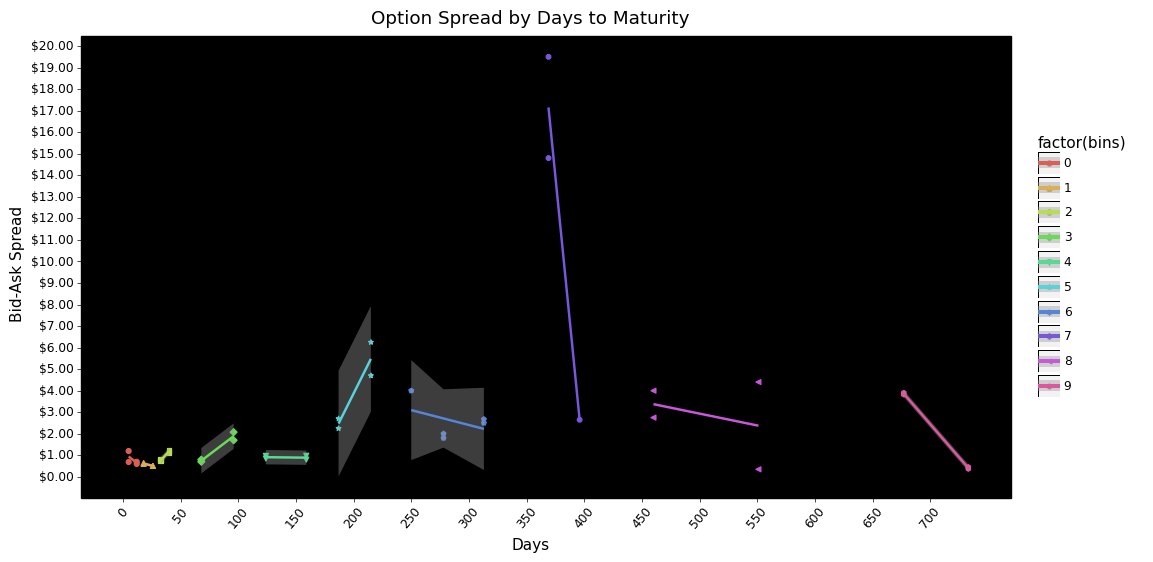

In [106]:
g = plot_spread_dtm(sprd_by_dtm)
g.save(filename='call-put option bid-ask spreads - daysToExpiration scatter plot.png')
g.draw();

### Selected Stock Options Only

In [168]:
median_sprd = data.groupby(['Ticker', 'Days', 'Call'],
                           as_index=False)['Spread'].median()

test_syms = ['NVDA', 'AMZN', 'MSFT']
sel_med_sprd = median_sprd.query('Ticker in @test_syms').dropna(subset=['Spread'])
# to plot symbols have to cast to type str
sel_med_sprd.Ticker = sel_med_sprd.Ticker.astype(str)
print(sel_med_sprd.head())
print(sel_med_sprd.info())

    Ticker  Days   Call  Spread
258   AMZN     5  False  12.175
259   AMZN    33  False  11.100
260   AMZN    96   True   8.300
261   AMZN   159  False   7.150
262   AMZN   159   True   7.850
<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 258 to 902
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ticker  20 non-null     object 
 1   Days    20 non-null     int64  
 2   Call    20 non-null     bool   
 3   Spread  20 non-null     float64
dtypes: bool(1), float64(1), int64(1), object(1)
memory usage: 660.0+ bytes
None


### How Do Bid-Ask Spreads Vary With Volume?

In [169]:
grp_cols = ['Ticker', 'Days', 'Call']
agg_cols = ['Spread', 'OpenInterest', 'Volume', 'IV', 'IntrinsicValue']
median_sprd = data.groupby(grp_cols, as_index=False)[agg_cols].median()

test_syms = ['NVDA', 'AMZN', 'MSFT']
sel_med_sprd = (median_sprd.query('Ticker in @test_syms')
                .dropna(subset=['Spread', 'OpenInterest']))

# to plot symbols have to cast to type str
sel_med_sprd.Ticker = sel_med_sprd.Ticker.astype(str)
sel_med_sprd.head()
print(sel_med_sprd.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 258 to 902
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Ticker          20 non-null     object 
 1   Days            20 non-null     int64  
 2   Call            20 non-null     bool   
 3   Spread          20 non-null     float64
 4   OpenInterest    20 non-null     float64
 5   Volume          20 non-null     float64
 6   IV              20 non-null     float64
 7   IntrinsicValue  20 non-null     float64
dtypes: bool(1), float64(5), int64(1), object(1)
memory usage: 1.3+ KB
None


In [170]:
def plot_log_points(df, x, y, color='factor(Ticker)', size='OpenInterest'):
    g = (pn.ggplot(df, pn.aes(x, y, color=color))
         + pn.geom_point(pn.aes(size=size))
         + pn.scale_x_log10(breaks=[0,0.5,1,10,100,250,500,750,1_000])
         + pn.theme_linedraw()
         + pn.theme(figure_size=(12,6), panel_background=pn.element_rect(fill='black'), 
                    axis_text_x=pn.element_text(rotation=50))
         + pn.scale_y_continuous(breaks=range(0, int(df.Spread.max()+2)),
                                 labels=mzf.currency_format(), limits=(0, df.Spread.max()))
         + pn.ylab('Bid-Ask Spread'))
    return g

/Users/mw/opt/anaconda3/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 12 x 6 in image.
/Users/mw/opt/anaconda3/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: call-put option bid-ask spreads - volume scatter plot.png
/Users/mw/opt/anaconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:697: RuntimeWarning: divide by zero encountered in log10
/Users/mw/opt/anaconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:697: RuntimeWarning: divide by zero encountered in log10


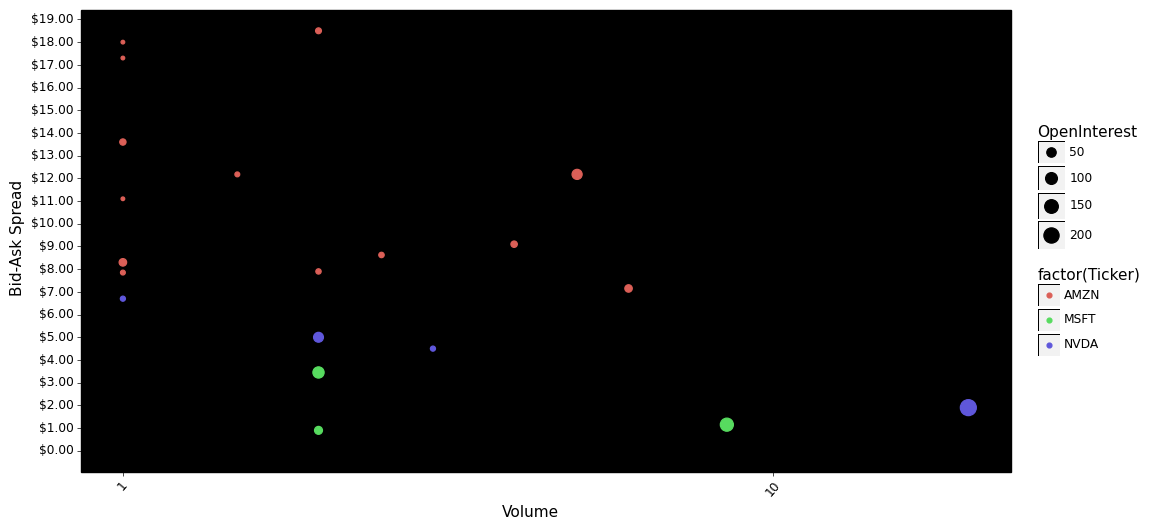

In [171]:
df = sel_med_sprd.copy()

# example with both call and puts
g = plot_log_points(df, x='Volume', y='Spread')
g.save(filename='call-put option bid-ask spreads - volume scatter plot.png')
g.draw();

/Users/mw/opt/anaconda3/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 12 x 6 in image.
/Users/mw/opt/anaconda3/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: call-put option bid-ask spreads - volatility scatter plot.png
/Users/mw/opt/anaconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:697: RuntimeWarning: divide by zero encountered in log10
/Users/mw/opt/anaconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:697: RuntimeWarning: divide by zero encountered in log10


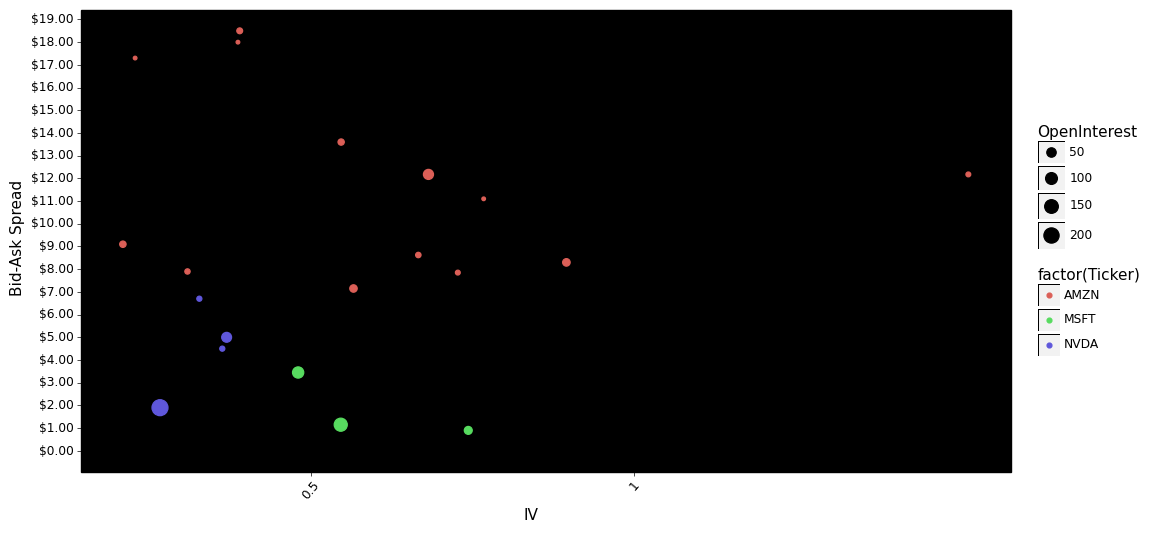

In [172]:

g = plot_log_points(df, 'IV', 'Spread')
g.save(filename='call-put option bid-ask spreads - volatility scatter plot.png')
g.draw();
